# Portfolio-Exam Part I - Sentiment Analysis

* Social Media Analytics - MADS-SMA
* Valentin Werger

In [1]:
# Compare different approaches
# Train own word embedding
# Use model trained on yelp for other data
# Try out sentiments towards types of entities

In [1]:
# Loading required ML packages and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.downloader

In [3]:
# Read Hamburg Yelp reviews
yelp = pd.read_csv("data/yelp_reviews_hamburg_en.csv", parse_dates=["date"])

In [4]:
# Overview of the data
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     3025 non-null   object        
 1   stars   3025 non-null   float64       
 2   text    3025 non-null   object        
 3   date    3025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 94.7+ KB


In [5]:
# Show the top 5 rows
yelp.head(5)

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,5.0,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,3.0,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,I love Campus Suite franchise. after the Balza...,2010-01-15


In [6]:
# Extract name of the location from url
yelp["name"] = yelp.apply(lambda row: re.sub("https://www.yelp.com/biz/", "", row["url"]), axis=1)
yelp = yelp.drop(columns="url")

<AxesSubplot:ylabel='Count'>

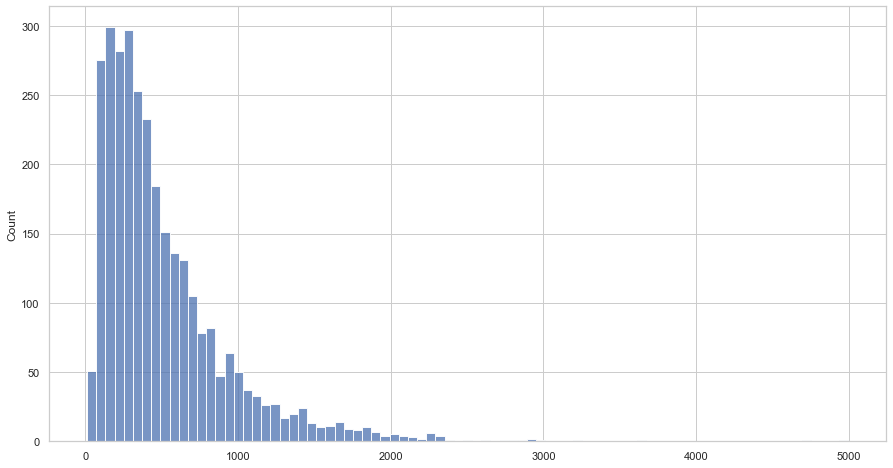

In [7]:
# Inspect length of review text
text_length_distribution = np.array([len(text) for text in yelp.text])

sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.histplot(data = text_length_distribution)

# Problem: Maximum length of Bert is 512


In [ ]:
# Check distribution of ratings
rating_counts = yelp.stars.value_counts()

sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.histplot(data = text_length_distribution)

In [8]:
# Load potential sets of word vectors
#list(gensim.downloader.info()['models'].keys())
potential_wv = {}
print("Downloading glove-wiki-gigaword-50")
potential_wv["wv_glove_wiki"] = gensim.downloader.load('glove-wiki-gigaword-300')
print("Downloading glove-twitter-50")
potential_wv["wv_glove_twitter"] = gensim.downloader.load('glove-twitter-200')
print("Downloading word2vec-google-news-300")
potential_wv["wv_word2vec"] = gensim.downloader.load('word2vec-google-news-300')

In [145]:
# Sentiment Analyser class
class SentimentAnalyser():

    def __init__(self, data, target, normalize = True):
        self.data = data
        self.target = target
        self.target_distribution = self.data[self.target].value_counts(normalize=True)

        # Normalize the review texts
        if normalize:
            self.data["text"] = self.normalize()

        # Initialize container for experiment results
        self.experiment_results = {}
        self.__run = 1

        # Produce word embeddings for the whole dataset
        self.word_embeddings = {}
        for vector_set in ["wv_glove_wiki", "wv_glove_twitter", "wv_word2vec"]:
            self.word_embeddings[vector_set] = self.__produce_embeddings(self.data.text, vector_set)

        # Set up experiments to conduct
        self.experiments = [
            {
                'name': 'Logistic Regression',
                'model': LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5),
                'params': {
                    'preprocessor': [
                        self.__WordCountTransformerHelper(min_df=1, ngram_range=(1,1)),
                        self.__WordCountTransformerHelper(min_df=2, ngram_range=(1,1)),
                        self.__WordCountTransformerHelper(min_df=3, ngram_range=(1,1)),
                        self.__WordCountTransformerHelper(min_df=1, ngram_range=(1,2)),
                        self.__TfidfTransformerHelper(norm="l2"),
                        self.__TfidfTransformerHelper(norm="l1"),
                        FunctionTransformer(self.__word_embedding_helper_function, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.__word_embedding_helper_function, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.__word_embedding_helper_function, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
                    'estimator__C': [0.5, 1, 2]
                }
            },
            {
                'name': 'KNeighbors',
                'model': KNeighborsClassifier(algorithm = "auto", n_jobs = os.cpu_count() -1),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__n_neighbors': randint(1, 10), 
                    'estimator__weights': ["uniform", "distance"], 
                    'estimator__metric': ["euclidean", "manhattan"]
                }
            },
            {
                'name': 'Random Forest',
                'model': RandomForestClassifier(n_jobs = os.cpu_count() -1, verbose = 1, random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__criterion': ['gini', 'entropy'],
                    'estimator__n_estimators': randint(1, 100), 
                    'estimator__max_features': uniform(0.1,0.9),
                    'estimator__class_weight': [None, 'balanced', 'balanced_subsample'],
                    'estimator__ccp_alpha': uniform(0,0.1)
                }
            },
            {
                'name': 'SVM',
                'model': SVC(verbose = True, random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__C': uniform(0.001, 1),
                    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'estimator__degree': randint(1, 5),
                    'estimator__gamma': uniform(0.0001, 1),
                    'estimator__class_weight': [None, 'balanced']
                }
            },
            # When in doubt use XGBoost
            {
                'name': 'XGBoost',
                'model': XGBClassifier(
                    objective = "multi:softprob",
                    num_class = 5, 
                    tree_method = "auto",
                    eval_metric = "auc", 
                    verbosity = 1,
                    use_label_encoder = False,
                    random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.__produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__learning_rate': uniform(0.001, 0.5),
                    'estimator__gamma': uniform(0, 0.5),
                    'estimator__max_depth': randint(3, 10),
                    'estimator__colsample_bytree': uniform(0.5, 0.5)
                }
            }
        ]

    def __normalize_document(self, doc, tokenizer, stop_words):
        doc = re.sub(r'@[\w]+', '', doc)          # replace user mentions
        doc = re.sub(r'http[\S]+', 'URL', doc)    # replace URLs
        doc = re.sub(r'[^\w\s]', '', doc)         # keep words and spaces
        doc = doc.lower()
        doc = doc.strip()
        tokens = tokenizer.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        doc = ' '.join(filtered_tokens)
        return doc

    def normalize(self):
        stop_words = nltk.corpus.stopwords.words('english')
        wpt = nltk.WordPunctTokenizer()

        return self.data.text.apply(lambda x: self.__normalize_document(x, wpt, stop_words))

    def naive_baseline(self):
        self.data["naive_baseline_prediction"] = np.random.choice(self.target_distribution.index.to_numpy(), size = len(self.data), replace = True, p = self.target_distribution.values)

    def vader_sentiment(self):
        vader = SentimentIntensityAnalyzer()
        self.data['vader_scores'] = self.data.text.apply(lambda x: vader.polarity_scores(x))
        self.data['vader_compound'] = self.data.vader_scores.apply(lambda x: x['compound'])
        self.data['vader_prediction'] = self.data.vader_compound.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.vader_prediction, normalize='all')

    def textblob_sentiment(self):
        self.data['textblob_score'] = self.data.text.apply(
            lambda review: TextBlob(review).sentiment[0])
        self.data['textblob_prediction'] = self.data.textblob_score.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.textblob_prediction, normalize='all')

    def __produce_embeddings(self, X, wv):
        print(f"Produce word embeddings for - {wv}")

        vocabulary = set(potential_wv[wv].index_to_key)
        wpt = nltk.WordPunctTokenizer()

        def avg_embeddings(document):
            words = wpt.tokenize(document)
            invocab = [word for word in words if word in vocabulary]
            avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
            return avg

        doc_embeddings = np.array([avg_embeddings(doc) for doc in X.values])
        return doc_embeddings

    def __word_embedding_helper_function(self, X, wv):
        embedding = self.word_embeddings[wv]
        return embedding[X]

    class __WordCountTransformerHelper(TransformerMixin, BaseEstimator):

        def __init__(self, min_df=1, ngram_range=(1,1)):
            self.min_df = min_df
            self.ngram_range = ngram_range
            self.transformer = CountVectorizer(min_df=self.min_df, ngram_range=self.ngram_range)

        def fit(self, X, y=None):
            self.transformer.fit(self.data.text[X])
            return self

        def transform(self, X):
            return self.transformer.transform(self.data.text[X])

    class __TfidfTransformerHelper(TransformerMixin, BaseEstimator):

        def __init__(self, norm="l2"):
            self.norm = norm
            self.transformer = TfidfTransformer(norm=self.norm)

        def fit(self, X, y=None):
            self.transformer.fit(self.data.text[X])
            return self

        def transform(self, X):
            return self.transformer.transform(self.data.text[X])


    def evaluate_classifier(self, name, model, params, iterations, cv_splits, cv_repeats):

        class Debug(BaseEstimator, TransformerMixin):

            def transform(self, X):
                print(X.shape)
                # what other output you want
                return X

            def fit(self, X, y=None, **fit_params):
                return self

        # The preprocessor set here is just a default and gets overwritten by the possible preprocessors in the parameter space
        pipeline = Pipeline([("debug1", Debug()), ('preprocessor', CountVectorizer()), ("debug2", Debug()), ('oversampler', SMOTE()), ('estimator', model)])

        # Setting up the Cross validation
        inner_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)
        outer_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)

        # Doing hyperparameter optimization
        optimization = RandomizedSearchCV(
            estimator = pipeline,
            param_distributions = params,
            scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
            cv = inner_cv,
            refit = 'roc_auc_ovo_weighted',
            n_iter = iterations,
            n_jobs = os.cpu_count() -1,
            verbose = 1,
            random_state = 33)

        optimization.fit(np.array(range(len(self.data))), self.data[self.target])

        # Evaluating the best model on the outer cross validation
        performance_estimation = cross_validate(
            estimator = optimization,
            X = np.array(range(len(self.data))),
            y = self.data[self.target],
            scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
            cv = outer_cv,
            n_jobs = os.cpu_count() -1)

        return(
        {
            'name': name,
            'optimization_cv_results': pd.DataFrame(optimization.cv_results_),
            'best_params': optimization.best_params_,
            'best_model': optimization.best_estimator_,
            'acc': performance_estimation['test_accuracy'],
            'balanced_acc': performance_estimation['test_balanced_accuracy'],
            'f1': performance_estimation['test_f1_weighted'],
            'roc_auc': performance_estimation['test_roc_auc_ovo_weighted']
        }
        )

    def run_experiments(self, iterations, cv_splits, cv_repeats, models = None):

        self.experiment_results[f"run_{self.__run}"] = {}

        # Determine which models to test
        if models:
            experiments = [experiment for experiment in self.experiments if experiment["name"] in models]
        else:
            experiments = self.experiments

        # Run experiment per model type
        for experiment in experiments:

            # Skip SVM
            if experiment['name'] == 'SVM':
                continue

            start_time= time.time()

            print()
            print()
            print(experiment['name'])
            print("-----------------")

            self.experiment_results[f"run_{self.__run}"][experiment['name']] = self.evaluate_classifier(
                    name = experiment['name'],
                    model = experiment['model'],
                    params = experiment['params'],
                    iterations = iterations,
                    cv_splits = cv_splits,
                    cv_repeats = cv_repeats
                )

            end_time = time.time() - start_time
            print(f'Time: {int(round(end_time, 1))} seconds ({int(round(end_time/60, 1))} minutes)')

        self.__run += 1
            

In [130]:
class word_count_transformer_helper(TransformerMixin, BaseEstimator):

    def __init__(self, min_df, ngram_range):
        self.transformer = CountVectorizer(min_df=min_df, ngram_range=ngram_range)

    def fit(self, X, y=None):
        self.transformer.fit(yelp.text[X])
        return self

    def transform(self, X):
        return self.transformer.transform(yelp.text[X])

test = word_count_transformer_helper(min_df = 1, ngram_range = (1,1))

In [135]:
params = {
    'preprocessor': [
        word_count_transformer_helper(min_df = 1, ngram_range = (1,1)), 
        #FunctionTransformer(word_count_helper_function, kw_args={'min_df':2}), 
        #FunctionTransformer(word_count_helper_function, kw_args={'min_df':3}), 
        #FunctionTransformer(word_count_helper_function, kw_args={'ngram_range':(1,2)})
        #FunctionTransformer(self.tfidf_helper_function, kw_args={'norm':"l1"}),
        #FunctionTransformer(self.tfidf_helper_function, kw_args={'norm':"l2"})
        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_glove_wiki"}),
        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_glove_twitter"}),
        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_word2vec"})
        ],
    'oversampler': ['passthrough'], #SMOTE(random_state=33)],
    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
    'estimator__C': [0.5, 1, 2]
}

In [141]:
def word_count_helper_function(X, min_df=1, ngram_range=(1,1)):
    text_input = yelp.text[X]
    transformer = CountVectorizer(min_df=min_df, ngram_range=ngram_range)
    counts = transformer.fit_transform(text_input)
    return counts

class word_count_transformer_helper(TransformerMixin, BaseEstimator):

    def __init__(self, min_df, ngram_range):
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.transformer = CountVectorizer(min_df=self.min_df, ngram_range=self.ngram_range)

    def fit(self, X, y=None):
        self.transformer.fit(yelp.text[X])
        return self

    def transform(self, X):
        return self.transformer.transform(yelp.text[X])

params = {
    'preprocessor': [
        word_count_transformer_helper(min_df = 1, ngram_range = (1,1)), 
        #FunctionTransformer(word_count_helper_function, kw_args={'min_df':2}), 
        #FunctionTransformer(word_count_helper_function, kw_args={'min_df':3}), 
        #FunctionTransformer(word_count_helper_function, kw_args={'ngram_range':(1,2)})
        #FunctionTransformer(self.tfidf_helper_function, kw_args={'norm':"l1"}),
        #FunctionTransformer(self.tfidf_helper_function, kw_args={'norm':"l2"})
        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_glove_wiki"}),
        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_glove_twitter"}),
        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_word2vec"})
        ],
    'oversampler': ['passthrough'], #SMOTE(random_state=33)],
    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
    'estimator__C': [0.5, 1, 2]
}

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

# The preprocessor set here is just a default and gets overwritten by the possible preprocessors in the parameter space
pipeline = Pipeline([("debug1", Debug()), ('preprocessor', CountVectorizer()), ('oversampler', SMOTE()), ('estimator', LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5))])
#pipeline.fit(np.array(range(len(yelp))), yelp["stars"])
#print(pipeline.score(np.array(range(len(yelp))), yelp["stars"]))

# Setting up the Cross validation
inner_cv = RepeatedKFold(n_splits = 3, n_repeats = 1, random_state = 33)
outer_cv = RepeatedKFold(n_splits = 3, n_repeats = 1, random_state = 33)

# Doing hyperparameter optimization
optimization = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
    cv = inner_cv,
    refit = 'roc_auc_ovo_weighted',
    n_iter = 3,
    n_jobs = os.cpu_count() -1,
    verbose = 1,
    random_state = 33,
    error_score="raise")

optimization.fit(np.array(range(len(yelp))), yelp["stars"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
(3025,)


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=33),
                   error_score='raise',
                   estimator=Pipeline(steps=[('debug1', Debug()),
                                             ('preprocessor',
                                              CountVectorizer()),
                                             ('oversampler', SMOTE()),
                                             ('estimator',
                                              LogisticRegression(l1_ratio=0.5,
                                                                 n_jobs=7,
                                                                 solver='saga'))]),
                   n_iter=3, n_jobs=7,
                   param_distributions={'estimator__C': [0.5, 1, 2],
                                        'estimator__penalty': ['none', 'l2',
                                                               'l1',
                                                               'elasticnet'],
                                        'oversampler': ['passthrough'],
                                        'preprocessor': [word_count_transformer_helper(min_df=1,
                                                                                       ngram_range=(1,
                                                                                                    1))]},
                   random_state=33, refit='roc_auc_ovo_weighted',
                   scoring=['accuracy', 'balanced_accuracy', 'f1_weighted',
                            'roc_auc_ovo_weighted'],
                   verbose=1)

In [142]:
optimization.cv_results_

{'mean_fit_time': array([ 1.39322535, 18.0493141 ,  1.25904115]),
 'std_fit_time': array([0.0288245 , 2.02765123, 0.0911937 ]),
 'mean_score_time': array([0.31859668, 0.13458967, 0.22503209]),
 'std_score_time': array([0.03788537, 0.03249213, 0.08643384]),
 'param_preprocessor': masked_array(data=[word_count_transformer_helper(min_df=1, ngram_range=(1, 1)),
                    word_count_transformer_helper(min_df=1, ngram_range=(1, 1)),
                    word_count_transformer_helper(min_df=1, ngram_range=(1, 1))],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_oversampler': masked_array(data=['passthrough', 'passthrough', 'passthrough'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_estimator__penalty': masked_array(data=['none', 'elasticnet', 'l2'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_estimator__C': masked_a

In [ ]:
def word_embedding_helper_function(self, X, wv):
    embedding = self.word_embeddings[wv]
    return embedding[X]

def word_count_helper_function(self, X, min_df=1, ngram_range=(1,1)):
    text_input = np.array(self.data.text)[X]
    transformer = CountVectorizer(min_df=min_df, ngram_range=ngram_range)
    return transformer.fit_transform(text_input)

def tfidf_helper_function(self, X, norm):
    text_input = np.array(self.data.text)[X]
    transformer = TfidfVectorizer(norm=norm)
    return transformer.fit_transform(text_input)


params = {
'oversampler': ['passthrough', SMOTE(random_state=33)],
'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
'estimator__C': [0.5, 1, 2]
}


# The preprocessor set here is just a default and gets overwritten by the possible preprocessors in the parameter space
pipeline = Pipeline([('preprocessor', FunctionTransformer(word_count_helper_function)), ('oversampler', SMOTE()), ('estimator', LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5))])

# Setting up the Cross validation
inner_cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 33)
outer_cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 33)

# Doing hyperparameter optimization
optimization = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
    cv = inner_cv,
    refit = 'roc_auc_ovo_weighted',
    n_iter = 5,
    n_jobs = os.cpu_count() -1,
    verbose = 1,
    random_state = 33)

optimization.fit(np.array(range(len(yelp))), yelp.stars)

Preprocessing needs to be part of pipeline to prevent data leakage or cheating the out of vocabulary problem - additional computational cost

Advantages of pipeline

Convenience and encapsulation
You only have to call fit and predict once on your data to fit a whole sequence of estimators.

Joint parameter selection
You can grid search over parameters of all estimators in the pipeline at once.

Safety
Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [146]:
# Initialize the Sentiment Analyser
sentiment = SentimentAnalyser(yelp, "stars", normalize=True)

Produce word embeddings for - wv_glove_wiki
Produce word embeddings for - wv_glove_twitter
Produce word embeddings for - wv_word2vec


In [147]:
sentiment.naive_baseline()

In [148]:
sentiment.vader_sentiment()

In [149]:
sentiment.textblob_sentiment()

In [151]:
sentiment.run_experiments(3, 2, 1, ["Logistic Regression"])



Logistic Regression
-----------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [97]:
sentiment.run_experiments(3, 2, 1, ["Logistic Regression"])



Logistic Regression
-----------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.50578736        nan        nan]
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.26541201        nan        nan]
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.44338571        nan        nan]
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.76371486        nan        nan]
  warnings.warn(


[   0    1    2 ... 3022 3023 3024]
[[-0.0231393   0.04741233  0.01614293 ... -0.02514256  0.04803576
   0.00268555]
 [-0.02278455  0.04631694 -0.02104378 ... -0.00500965  0.05541738
  -0.00547345]
 [ 0.00243906  0.02151313 -0.00636644 ... -0.03804838  0.00852438
  -0.01802885]
 ...
 [ 0.00030435  0.04760577  0.02483141 ... -0.01444306  0.03530873
   0.00304269]
 [ 0.0184044   0.04695504  0.02700057 ... -0.04469659  0.01335864
   0.0114487 ]
 [ 0.02122582  0.03601752  0.05741713 ... -0.09107801  0.01724688
   0.0259196 ]]
Time: 65 seconds (1 minutes)


In [85]:
sentiment.experiment_results["run_1"]["Logistic Regression"]["optimization_cv_results"]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor,param_oversampler,param_estimator__penalty,param_estimator__C,params,split0_test_accuracy,...,split0_test_f1_weighted,split1_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovo_weighted,split1_test_roc_auc_ovo_weighted,mean_test_roc_auc_ovo_weighted,std_test_roc_auc_ovo_weighted,rank_test_roc_auc_ovo_weighted
0,4.780407,0.543702,0.096499,0.007501,FunctionTransformer(func=<bound method Sentime...,passthrough,elasticnet,1,{'preprocessor': FunctionTransformer(func=<bou...,0.499009,...,0.441208,0.445563,0.443386,0.002178,1,0.759383,0.768054,0.763719,0.004336,1
1,0.893004,0.129515,0.182261,0.056265,FunctionTransformer(func=<bound method Sentime...,passthrough,none,2,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2
2,0.571842,0.112156,0.127510,0.001489,FunctionTransformer(func=<bound method Sentime...,passthrough,none,1,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,3


In [91]:
import cProfile
cProfile.run('sentiment.run_experiments(3, 2, 1, ["Logistic Regression"])')



Logistic Regression
-----------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


         15940 function calls (15439 primitive calls) in 59.862 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   59.861   59.861 3837047588.py:214(evaluate_classifier)
        1    0.000    0.000    0.000    0.000 3837047588.py:216(Debug)
        1    0.000    0.000   59.861   59.861 3837047588.py:269(run_experiments)
        1    0.000    0.000    0.000    0.000 3837047588.py:275(<listcomp>)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(all)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(amin)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(any)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(bincount)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(concatenate)
        2    0.000    0.000    0.000    0.000 <__array_function__ in

ValueError: 
All the 6 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ValentinStudium\Envs\sma\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\ValentinStudium\Envs\sma\lib\site-packages\imblearn\pipeline.py", line 190, in _fit
    self._validate_steps()
  File "c:\Users\ValentinStudium\Envs\sma\lib\site-packages\imblearn\pipeline.py", line 125, in _validate_steps
    self._validate_names(names)
  File "c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\utils\metaestimators.py", line 86, in _validate_names
    raise ValueError("Names provided are not unique: {0!r}".format(list(names)))
ValueError: Names provided are not unique: ['debug', 'preprocessor', 'debug', 'oversampler', 'estimator']


In [22]:
sentiment.experiment_results["run_1"]["Logistic Regression"]["optimization_cv_results"]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor,param_oversampler,param_estimator__penalty,param_estimator__C,params,split0_test_accuracy,...,split0_test_f1_weighted,split1_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovo_weighted,split1_test_roc_auc_ovo_weighted,mean_test_roc_auc_ovo_weighted,std_test_roc_auc_ovo_weighted,rank_test_roc_auc_ovo_weighted
0,6.885542,0.024955,3.880210,0.091795,FunctionTransformer(func=<bound method Sentime...,passthrough,l1,1,{'preprocessor': FunctionTransformer(func=<bou...,0.512227,...,0.487479,0.487753,0.487616,0.000137,1,0.762245,0.767468,0.764857,0.002612,2
1,14.656642,0.489798,3.721914,0.740914,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),l1,1,{'preprocessor': FunctionTransformer(func=<bou...,0.456048,...,0.472759,0.494656,0.483707,0.010948,2,0.764429,0.794294,0.779361,0.014932,1
2,3.768894,0.743547,2.502676,0.046372,FunctionTransformer(func=<bound method Sentime...,passthrough,l2,0.5,{'preprocessor': FunctionTransformer(func=<bou...,0.511566,...,0.474067,0.465805,0.469936,0.004131,3,0.758581,0.761004,0.759792,0.001211,3


In [79]:
transformed_data = CountVectorizer().fit_transform(yelp.text)
model = LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5)
model.fit(X = transformed_data, y = yelp.stars)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.5, n_jobs=7, solver='saga')

In [83]:
model.score(X = transformed_data, y = yelp.stars)

0.9550413223140496

In [141]:
pipeline = Pipeline([('preprocessor', CountVectorizer()), ('oversampler', SMOTE()), ('estimator',  LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5, max_iter=1000))])
pipeline.fit(yelp.text, yelp.stars)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor', CountVectorizer()), ('oversampler', SMOTE()),
                ('estimator',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000, n_jobs=7,
                                    solver='saga'))])

In [107]:
pipeline.score(yelp.text, yelp.stars)

0.9920661157024794

In [113]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yelp.stars, pipeline.predict_proba(yelp.text))

ValueError: multi_class must be in ('ovo', 'ovr')

In [144]:
def produce_embeddings(X, wv):
    print(wv)
    if wv not in ["wv_glove_wiki","wv_glove_twitter","wv_word2vec"]:
        print("Not a valid set of word vectors - Choose one of the following")
        print(["wv_glove_wiki","wv_glove_twitter","wv_word2vec"])

    vocabulary = set(potential_wv[wv].index_to_key)
    wpt = nltk.WordPunctTokenizer()

    def avg_embeddings(document):
        words = wpt.tokenize(document)
        invocab = [word for word in words if word in vocabulary]
        avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
        return avg

    doc_embeddings = [avg_embeddings(doc) for doc in X.values]
    print(doc_embeddings)
    return doc_embeddings

params = {
    'preprocessor': [FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_glove_wiki"})],
    'oversampler': ['passthrough', SMOTE(random_state=33)]
}

inner_cv = RepeatedKFold(n_splits = 2, n_repeats = 1, random_state = 33)
outer_cv = RepeatedKFold(n_splits = 2, n_repeats = 1, random_state = 33)

# Doing hyperparameter optimization
optimization = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
    cv = inner_cv,
    refit = 'roc_auc_ovo_weighted',
    n_iter = 5,
    n_jobs = os.cpu_count() -1,
    verbose = 1,
    random_state = 33)

#print(input.shape)
#print(input)
#print(self.data[self.target].shape)
#print(self.data[self.target])
optimization.fit(yelp.text, yelp.stars)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [143]:
optimization.cv_results_

{'mean_fit_time': array([5.44463897, 7.33878958]),
 'std_fit_time': array([0.56282735, 0.98143685]),
 'mean_score_time': array([5.38122666, 2.46106195]),
 'std_score_time': array([0.95839632, 0.35805845]),
 'param_preprocessor': masked_array(data=[FunctionTransformer(func=<function produce_embeddings at 0x00000263C45800D0>,
                                        kw_args={'wv': 'wv_glove_wiki'})                         ,
                    FunctionTransformer(func=<function produce_embeddings at 0x00000263C45800D0>,
                                        kw_args={'wv': 'wv_glove_wiki'})                         ],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_oversampler': masked_array(data=['passthrough', SMOTE(random_state=33)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'preprocessor': FunctionTransformer(func=<function produce_embeddings at 0x00000263C45800D0>,
               

In [115]:
optimization.cv_results_

{'mean_fit_time': array([3.50885952, 9.40877807]),
 'std_fit_time': array([0.62279022, 0.69137371]),
 'mean_score_time': array([0.22923148, 0.17882931]),
 'std_score_time': array([0.06071699, 0.02544558]),
 'param_oversampler': masked_array(data=['passthrough', SMOTE(random_state=33)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'oversampler': 'passthrough'},
  {'oversampler': SMOTE(random_state=33)}],
 'split0_test_accuracy': array([0.53139458, 0.48182419]),
 'split1_test_accuracy': array([0.52910053, 0.49801587]),
 'mean_test_accuracy': array([0.53024755, 0.48992003]),
 'std_test_accuracy': array([0.00114703, 0.00809584]),
 'rank_test_accuracy': array([1, 2]),
 'split0_test_balanced_accuracy': array([0.38302699, 0.4135917 ]),
 'split1_test_balanced_accuracy': array([0.35831764, 0.38671666]),
 'mean_test_balanced_accuracy': array([0.37067231, 0.40015418]),
 'std_test_balanced_accuracy': array([0.01235468, 0.01343752]),
 'rank_tes

In [95]:
def produce_embeddings(X, wv):
    print(wv)
    if wv not in ["wv_glove_wiki","wv_glove_twitter","wv_word2vec"]:
        print("Not a valid set of word vectors - Choose one of the following")
        print(["wv_glove_wiki","wv_glove_twitter","wv_word2vec"])

    vocabulary = set(potential_wv[wv].index_to_key)
    wpt = nltk.WordPunctTokenizer()

    def avg_embeddings(document):
        words = wpt.tokenize(document)
        invocab = [word for word in words if word in vocabulary]
        avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
        return avg

    doc_embeddings = [avg_embeddings(doc) for doc in X.values]
    return doc_embeddings

params = {
    'preprocessor': [
        CountVectorizer(min_df=1), 
        CountVectorizer(min_df=2), 
        CountVectorizer(min_df=3), 
        CountVectorizer(ngram_range=(1,2)),
        TfidfVectorizer(norm= 'l1'),
        TfidfVectorizer(norm = 'l2'),
        FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
        FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
        FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_word2vec"})
        ],
    'oversampler': ['passthrough', SMOTE(random_state=33)],
    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
    'estimator__C': [0.5, 1, 2]
}

params = {
    'oversampler': ['passthrough', SMOTE(random_state=33)]
}

inner_cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 33)
outer_cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 33)

# Doing hyperparameter optimization
optimization = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc'],
    cv = inner_cv,
    refit = 'roc_auc',
    n_iter = 5,
    n_jobs = os.cpu_count() -1,
    verbose = 1,
    random_state = 33)

#print(input.shape)
#print(input)
#print(self.data[self.target].shape)
#print(self.data[self.target])
optimization.fit(yelp.text, yelp.stars)

# Evaluating the best model on the outer cross validation
performance_estimation = cross_validate(
    estimator = optimization,
    X = yelp.text,
    y = yelp.stars,
    scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc'],
    cv = outer_cv,
    n_jobs = -1)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [96]:
optimization.cv_results_

{'mean_fit_time': array([0.5789814 , 1.25538003]),
 'std_fit_time': array([0.13088441, 0.00751984]),
 'mean_score_time': array([0.08575821, 0.0890162 ]),
 'std_score_time': array([0.00524211, 0.00301719]),
 'param_oversampler': masked_array(data=['passthrough', SMOTE(random_state=33)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'oversampler': 'passthrough'},
  {'oversampler': SMOTE(random_state=33)}],
 'split0_test_accuracy': array([nan, nan]),
 'split1_test_accuracy': array([nan, nan]),
 'mean_test_accuracy': array([nan, nan]),
 'std_test_accuracy': array([nan, nan]),
 'rank_test_accuracy': array([1, 2]),
 'split0_test_balanced_accuracy': array([nan, nan]),
 'split1_test_balanced_accuracy': array([nan, nan]),
 'mean_test_balanced_accuracy': array([nan, nan]),
 'std_test_balanced_accuracy': array([nan, nan]),
 'rank_test_balanced_accuracy': array([1, 2]),
 'split0_test_f1': array([nan, nan]),
 'split1_test_f1': array([nan, nan]),

In [71]:
sentiment.experiment_results["run_1"]["Logistic Regression"]["optimization_cv_results"]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor,param_oversampler,param_estimator__penalty,param_estimator__C,params,split0_test_accuracy,...,split0_test_f1,split1_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.717501,0.000503,0.117499,0.003503,CountVectorizer(),passthrough,none,2,"{'preprocessor': CountVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1
1,19.886458,0.154257,0.125498,0.019500,CountVectorizer(),SMOTE(random_state=33),l1,2,"{'preprocessor': CountVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2
2,9.337158,0.070497,0.000000,0.000000,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),elasticnet,2,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,3
3,13.607074,1.314542,0.000000,0.000000,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),none,0.5,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,4
4,13.117513,1.867869,0.000000,0.000000,FunctionTransformer(func=<bound method Sentime...,passthrough,none,0.5,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,5
5,1.996702,0.037999,0.209499,0.017500,TfidfVectorizer(norm='l1'),passthrough,l1,2,"{'preprocessor': TfidfVectorizer(norm='l1'), '...",NaN,...,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,6
6,20.287348,0.243974,0.104000,0.019998,CountVectorizer(min_df=3),SMOTE(random_state=33),elasticnet,1,"{'preprocessor': CountVectorizer(min_df=3), 'o...",NaN,...,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7
7,1.538431,0.144711,0.286506,0.023013,TfidfVectorizer(norm='l1'),SMOTE(random_state=33),l2,2,"{'preprocessor': TfidfVectorizer(norm='l1'), '...",NaN,...,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,8
8,33.105094,0.957821,0.070483,0.007513,CountVectorizer(),SMOTE(random_state=33),elasticnet,2,"{'preprocessor': CountVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,9
9,4.031324,0.361381,0.193499,0.022498,TfidfVectorizer(),passthrough,elasticnet,2,"{'preprocessor': TfidfVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,10


In [ ]:
sentiment.run_experiments(10, 3, 1, [""])

In [ ]:
sentiment.experiments

In [ ]:
# Sentiment analysis on the document level

# 1. Rule based
    # Vader
    # Text Blob
# 2. ML based - Classification or Regression?
    # own feature engineering plus defined models
        # bag of words
        # TD-IF
        # word vectors
    # Transformers